### Building evasion vs. mean time interval : by Bus by Service

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import datetime as dt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
from Utils import TransantiagoConstants
import EvasionBuilder

In [4]:
processed_evasion = EvasionBuilder.runCompleteProcess()

Original number of rows in complete evasion database is: 97373
Number of duplicated rows in complete evasion database is: 6192
Number of collapsed-duplicated rows in complete evasion database is: 3090
Number of rows in complete evasion database without duplicated rows at all is: 91181
Final number of rows in complete evasion database with collapsed duplicated rows is: 94271


C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


The only non-matched user_code services are: 
D06


* Processing evasion-ddbb before merging

In [5]:
evasion_paradero = processed_evasion[processed_evasion['TP']=='P']
evasion_paradero_first = evasion_paradero[evasion_paradero['N_PUERTA']==1]

* Getting evasion by date-bus-service

In [6]:
f = {'SERVICIO':['count'],'INGRESAN':['sum'], 'NO_VALIDAN':['sum']}

summary = evasion_paradero_first.groupby(['FECHA','PATENTE','SERVICIO']).agg(f)
summary.columns=['EVASION_COUNT', 'TOTAL_INGRESAN', 'TOTAL_NO_VALIDAN']
summary.reset_index(inplace=True)

* Computing evasion rate

In [7]:
summary.loc[:,'EVASION_RATE'] = summary.loc[:,'TOTAL_NO_VALIDAN']/summary.loc[:,'TOTAL_INGRESAN']

* Filtering by common_dates

In [8]:
common_dates = TransantiagoConstants.common_dates

In [9]:
common_dates_timestamp = [pd.to_datetime(x) for x in common_dates]

In [10]:
common_dates_evasion = summary[summary['FECHA'].isin(common_dates_timestamp)]

* Building complete etapas ddbb.

In [11]:
reduced_etapas = pd.DataFrame()

for date in common_dates:
    base_input_path = 'C:/Users/leoca_000/Desktop/Evasion/01_analisis/03_datos/01_SSH/02_TIMESBYBUSBYSERVICE/02_20SECS/'
    file_name = date + '-meanByBusByService.csv'
    grouped_by_bus = pd.read_csv(base_input_path+file_name, encoding = 'latin-1',sep =";")
    reduced_etapas = pd.concat([reduced_etapas,grouped_by_bus])


* Processing etapas ddbb before merging

In [12]:
del reduced_etapas['Unnamed: 0']
reduced_etapas = reduced_etapas.rename(columns = {'fecha':'FECHA', 'sitio_subida':'PATENTE', 'count': 'ETAPAS_COUNT', 'servicio_subida' : 'SERVICIO'})
reduced_etapas['FECHA'] = pd.to_datetime(reduced_etapas.FECHA)
reduced_etapas['PATENTE'] = reduced_etapas['PATENTE'].str.replace("-", "")
reduced_etapas['PATENTE'] = reduced_etapas['PATENTE'].str.replace(" ", "")

In [13]:
reduced_etapas.reset_index(drop=True,inplace=True)

In [14]:
type(reduced_etapas.loc[0,'FECHA'])

pandas._libs.tslib.Timestamp

In [15]:
type(reduced_etapas.loc[0,'fecha_instalacion'])

float

### Merging - 20Secs

In [16]:
evasion_vs_mean = pd.merge(summary,reduced_etapas, on=['FECHA','PATENTE','SERVICIO'], how='left')

In [17]:
print('Merged database contains: ' + str(len(evasion_vs_mean.index)) + ' rows.')

Merged database contains: 1184 rows.


* Getting rid of missing values

In [18]:
clean_evasion_vs_mean = evasion_vs_mean[evasion_vs_mean['mean'].notnull()]

In [19]:
print('Merged database with not-null mean time interval contains: ' + str(len(clean_evasion_vs_mean.index)) + ' rows.')

Merged database with not-null mean time interval contains: 481 rows.


* Computing if_turnstile

In [20]:
clean_evasion_vs_mean.loc[:,'fecha_instalacion'] = pd.to_datetime(clean_evasion_vs_mean.loc[:,'fecha_instalacion'])
clean_evasion_vs_mean.loc[:,'SI_TORNIQUETE'] = (clean_evasion_vs_mean.loc[:,'fecha_instalacion'].notnull())
clean_evasion_vs_mean.loc[:,'SI_2017_TORNIQUETE'] = (clean_evasion_vs_mean.loc[:,'fecha_instalacion']>pd.to_datetime('2017-01-01'))

C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [21]:
clean_evasion_vs_mean_no_turnstile = clean_evasion_vs_mean[(clean_evasion_vs_mean['SI_TORNIQUETE']==False) | 
                                                           ((clean_evasion_vs_mean['SI_TORNIQUETE']==True) & (clean_evasion_vs_mean['FECHA']<=clean_evasion_vs_mean['fecha_instalacion']))]

### Plotting - 20Secs

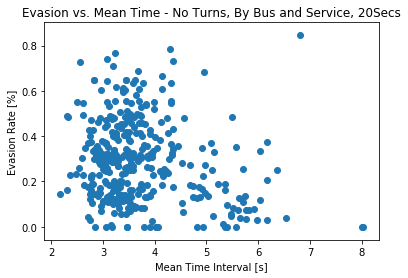

In [22]:
fig_1, ax_1 = plt.subplots()

ax_1.scatter(clean_evasion_vs_mean_no_turnstile['mean'],clean_evasion_vs_mean_no_turnstile['EVASION_RATE'])
ax_1.set_title('Evasion vs. Mean Time - No Turns, By Bus and Service, 20Secs')
ax_1.set_xlabel('Mean Time Interval [s]')
ax_1.set_ylabel('Evasion Rate [%]')

#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/8_20Secs_EvasionVsMeanTimeByBusByService.pdf')

### Analyzing - 20Secs

In [23]:
print('Merged database with not-null mean time interval and no-turnstile contains: ' + str(len(clean_evasion_vs_mean_no_turnstile.index)) + ' rows.')

Merged database with not-null mean time interval and no-turnstile contains: 359 rows.


In [24]:
print('Etapas_count MEAN: ' + str(clean_evasion_vs_mean_no_turnstile['ETAPAS_COUNT'].mean()))
print('Etapas_count MIN: ' + str(clean_evasion_vs_mean_no_turnstile['ETAPAS_COUNT'].min()))
print('Etapas_count MAX: ' + str(clean_evasion_vs_mean_no_turnstile['ETAPAS_COUNT'].max()))

print('Evasion_count MEAN: ' + str(clean_evasion_vs_mean_no_turnstile['EVASION_COUNT'].mean()))
print('Evasion_count MIN: ' + str(clean_evasion_vs_mean_no_turnstile['EVASION_COUNT'].min()))
print('Evasion_count MAX: ' + str(clean_evasion_vs_mean_no_turnstile['EVASION_COUNT'].max()))

Etapas_count MEAN: 191.9693593314763
Etapas_count MIN: 5.0
Etapas_count MAX: 815.0
Evasion_count MEAN: 28.96657381615599
Evasion_count MIN: 3
Evasion_count MAX: 116


* Checking for <strong>outlier 1</strong>

In [25]:
clean_evasion_vs_mean_no_turnstile[clean_evasion_vs_mean_no_turnstile['EVASION_RATE']>0.8]

,FECHA,PATENTE,SERVICIO,EVASION_COUNT,TOTAL_INGRESAN,TOTAL_NO_VALIDAN,EVASION_RATE,ETAPAS_COUNT,sum,mean,fecha_instalacion,SI_TORNIQUETE,SI_2017_TORNIQUETE
1021,2017-08-17,CJRG41,F18,27,71,60,0.84507,5.0,34.0,6.8,NaT,False,False


In [26]:
evasion_paradero_first[(evasion_paradero_first['FECHA']==pd.to_datetime('2017-08-17'))&(evasion_paradero_first['PATENTE']=='CJRG41')]

,FECHA,HORA,HORA_INICIO,INGRESAN,LUGAR_INICIO,MINUTO,NO_VALIDAN,N_PUERTA,PATENTE,PUERTAS,TIEMPO,TP,SERVICIO_USUARIO,UN,SERVICIO
79864,2017-08-17,18,18:20:00,4,AVENIDA JUANITA 01490,20,2,1,CJRG41,3,2017-08-17 18:20:00,P,F18,7.0,F18
79865,2017-08-17,18,18:20:00,10,AVENIDA JUANITA 01490,21,10,1,CJRG41,3,2017-08-17 18:21:00,P,F18,7.0,F18
79866,2017-08-17,18,18:20:00,2,AVENIDA JUANITA 01490,22,2,1,CJRG41,3,2017-08-17 18:22:00,P,F18,7.0,F18
79867,2017-08-17,18,18:20:00,2,AVENIDA JUANITA 01490,23,2,1,CJRG41,3,2017-08-17 18:23:00,P,F18,7.0,F18
79868,2017-08-17,18,18:20:00,4,AVENIDA JUANITA 01490,24,4,1,CJRG41,3,2017-08-17 18:24:00,P,F18,7.0,F18
79869,2017-08-17,18,18:20:00,3,AVENIDA JUANITA 01490,26,3,1,CJRG41,3,2017-08-17 18:26:00,P,F18,7.0,F18
79870,2017-08-17,18,18:20:00,3,AVENIDA JUANITA 01490,27,3,1,CJRG41,3,2017-08-17 18:27:00,P,F18,7.0,F18
79871,2017-08-17,18,18:20:00,2,AVENIDA JUANITA 01490,28,2,1,CJRG41,3,2017-08-17 18:28:00,P,F18,7.0,F18
79872,2017-08-17,18,18:20:00,1,AVENIDA JUANITA 01490,29,0,1,CJRG41,3,2017-08-17 18:29:00,P,F18,7.0,F18
79873,2017-08-17,18,18:20:00,3,AVENIDA JUANITA 01490,30,3,1,CJRG41,3,2017-08-17 18:30:00,P,F18,7.0,F18


In [27]:
import DailyEtapasBuilder
import re

In [28]:
date = '2017-08-17'
patente = 'CJRG-41'

etapas_builder = DailyEtapasBuilder.RunSilentlyDailyEtapasBuilderClass(date)
etapas_builder.loadSimplifiedEtapas()
etapas_builder.mergeTurnstileData()
etapas_builder.cleanDataFrame()
etapas_builder.sortDataFrame()
etapas_builder.postProcessingSortedDataFrame()
processed_sorted_df = etapas_builder.etapas_df

Not found in turnstile database: 1873694


In [38]:
processed_sorted_df[(processed_sorted_df['sitio_subida']==patente)&(processed_sorted_df['servicio_subida'].str.contains('F18'))&(processed_sorted_df['mismo_paradero']==True)&(processed_sorted_df['mismo_servicio']==True)]

,index,id,nviaje,tipo_transporte,t_subida,servicio_subida,par_subida,sitio_subida,fecha_instalacion,mismo_paradero,misma_patente,mismo_servicio,diferencia_tiempo,diferencia_tiempo_secs,si_torniquete,si_2017_torniquete
934339,2256649,3515750888,2,BUS,2017-08-17 18:34:40,F18 00I,L-34-83-26-SN,CJRG-41,NaT,True,True,True,00:00:02,2.0,False,False
934341,288614,61476130,2,BUS,2017-08-17 18:37:18,F18 00I,L-34-40-15-PO,CJRG-41,NaT,True,True,True,00:00:20,20.0,False,False
934345,795419,433835730,4,BUS,2017-08-17 18:44:01,F18 00I,L-34-40-75-PO,CJRG-41,NaT,True,True,True,00:00:03,3.0,False,False
934350,1653585,2501589086,3,BUS,2017-08-17 19:15:43,F18 00R,L-34-42-5-OP,CJRG-41,NaT,True,True,True,00:00:05,5.0,False,False
934356,490030,136879542,1,BUS,2017-08-17 19:39:03,F18 00R,L-34-40-5-OP,CJRG-41,NaT,True,True,True,00:00:04,4.0,False,False


* Checking for <strong>outlier 2</strong> and <strong>outlier 3</strong>

In [39]:
clean_evasion_vs_mean_no_turnstile[(clean_evasion_vs_mean_no_turnstile['EVASION_RATE']==0)&(clean_evasion_vs_mean_no_turnstile['mean']>=8)]

,FECHA,PATENTE,SERVICIO,EVASION_COUNT,TOTAL_INGRESAN,TOTAL_NO_VALIDAN,EVASION_RATE,ETAPAS_COUNT,sum,mean,fecha_instalacion,SI_TORNIQUETE,SI_2017_TORNIQUETE
741,2017-06-14,WG7194,F11,4,4,0,0.0,5.0,40.0,8.000000,NaT,False,False
1022,2017-08-17,CJRG57,F18,19,6,0,0.0,30.0,241.0,8.033333,NaT,False,False


* <strong>Outlier 2</strong>

In [40]:
date = '2017-06-14'
patente = 'WG-7194'

etapas_builder = DailyEtapasBuilder.RunSilentlyDailyEtapasBuilderClass(date)
etapas_builder.loadSimplifiedEtapas()
etapas_builder.mergeTurnstileData()
etapas_builder.cleanDataFrame()
etapas_builder.sortDataFrame()
etapas_builder.postProcessingSortedDataFrame()
processed_sorted_df = etapas_builder.etapas_df

Not found in turnstile database: 517700


In [42]:
processed_sorted_df[(processed_sorted_df['sitio_subida']==patente)&(processed_sorted_df['servicio_subida'].str.contains('F11'))&(processed_sorted_df['mismo_paradero']==True)&(processed_sorted_df['mismo_servicio']==True)&(processed_sorted_df['diferencia_tiempo_secs']<=20)]

,index,id,nviaje,tipo_transporte,t_subida,servicio_subida,par_subida,sitio_subida,fecha_instalacion,mismo_paradero,misma_patente,mismo_servicio,diferencia_tiempo,diferencia_tiempo_secs,si_torniquete,si_2017_torniquete
645553,25541,32898274,1,BUS,2017-06-14 12:45:39,F11 07R,L-34-31-45-OP,WG-7194,NaT,True,True,True,00:00:04,4.0,False,False
645597,474445,2505035118,3,BUS,2017-06-14 17:50:40,F11 00R,L-34-31-45-OP,WG-7194,NaT,True,True,True,00:00:03,3.0,False,False
645600,191426,423450002,1,BUS,2017-06-14 18:32:16,F11 00I,L-34-14-60-OP,WG-7194,NaT,True,True,True,00:00:05,5.0,False,False
645601,239064,558998090,2,BUS,2017-06-14 18:32:26,F11 00I,L-34-14-60-OP,WG-7194,NaT,True,True,True,00:00:10,10.0,False,False
645607,655915,3455532843,2,BUS,2017-06-14 20:05:42,F11 00I,L-34-76-20-SN,WG-7194,NaT,True,True,True,00:00:18,18.0,False,False


In [43]:
processed_sorted_df.loc[(processed_sorted_df['sitio_subida']==patente)&(processed_sorted_df['servicio_subida'].str.contains('F11'))&(processed_sorted_df['mismo_paradero']==True)&(processed_sorted_df['mismo_servicio']==True)&(processed_sorted_df['diferencia_tiempo_secs']<=20),'servicio_subida'].unique()

array(['F11 07R', 'F11 00R', 'F11 00I'], dtype=object)

* <strong>Outlier 3</strong>

In [44]:
date = '2017-08-17'
patente = 'CJRG-57'

etapas_builder = DailyEtapasBuilder.RunSilentlyDailyEtapasBuilderClass(date)
etapas_builder.loadSimplifiedEtapas()
etapas_builder.mergeTurnstileData()
etapas_builder.cleanDataFrame()
etapas_builder.sortDataFrame()
etapas_builder.postProcessingSortedDataFrame()
processed_sorted_df = etapas_builder.etapas_df

Not found in turnstile database: 1873694


In [46]:
processed_sorted_df[(processed_sorted_df['sitio_subida']==patente)&(processed_sorted_df['servicio_subida'].str.contains('F18'))&(processed_sorted_df['mismo_paradero']==True)&(processed_sorted_df['mismo_servicio']==True)&(processed_sorted_df['diferencia_tiempo_secs']<=20)]

,index,id,nviaje,tipo_transporte,t_subida,servicio_subida,par_subida,sitio_subida,fecha_instalacion,mismo_paradero,misma_patente,mismo_servicio,diferencia_tiempo,diferencia_tiempo_secs,si_torniquete,si_2017_torniquete
940894,2006513,3066195547,1,BUS,2017-08-17 17:05:09,F18 06R,E-34-294-PO-5,CJRG-57,NaT,True,True,True,00:00:09,9.0,False,False
940896,601929,266103090,2,BUS,2017-08-17 17:05:37,F18 06R,E-34-294-PO-5,CJRG-57,NaT,True,True,True,00:00:04,4.0,False,False
940897,147665,39182178,2,BUS,2017-08-17 17:05:45,F18 06R,E-34-294-PO-5,CJRG-57,NaT,True,True,True,00:00:08,8.0,False,False
940898,1771551,2641234174,2,BUS,2017-08-17 17:05:57,F18 06R,E-34-294-PO-5,CJRG-57,NaT,True,True,True,00:00:12,12.0,False,False
940899,1188808,1095846260,2,BUS,2017-08-17 17:06:01,F18 06R,E-34-294-PO-5,CJRG-57,NaT,True,True,True,00:00:04,4.0,False,False
940901,991364,602186530,1,BUS,2017-08-17 17:07:16,F18 06R,E-34-294-PO-5,CJRG-57,NaT,True,True,True,00:00:15,15.0,False,False
940902,1708312,2514974638,1,BUS,2017-08-17 17:07:19,F18 06R,E-34-294-PO-5,CJRG-57,NaT,True,True,True,00:00:03,3.0,False,False
940904,2570897,3952237003,1,BUS,2017-08-17 17:07:45,F18 06R,E-34-294-PO-5,CJRG-57,NaT,True,True,True,00:00:05,5.0,False,False
940905,854084,475014610,10,BUS,2017-08-17 17:07:47,F18 06R,E-34-294-PO-5,CJRG-57,NaT,True,True,True,00:00:02,2.0,False,False
940907,1683595,2510480030,1,BUS,2017-08-17 17:26:40,F18 06R,L-34-6-5-OP,CJRG-57,NaT,True,True,True,00:00:04,4.0,False,False


In [45]:
processed_sorted_df.loc[(processed_sorted_df['sitio_subida']==patente)&(processed_sorted_df['servicio_subida'].str.contains('F18'))&(processed_sorted_df['mismo_paradero']==True)&(processed_sorted_df['mismo_servicio']==True)&(processed_sorted_df['diferencia_tiempo_secs']<=20),'servicio_subida'].unique()

array(['F18 06R', 'F18 00R', 'F18 00I'], dtype=object)

# Temporarily Closed